# Toto: Zero-Shot Blood Glucose Forecasting

**Model**: Datadog/Toto-Open-Base-1.0 (151M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

Toto is a time-series foundation model trained on 2T observability metrics. It provides probabilistic forecasts with uncertainty quantiles.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from toto.model.toto import Toto
from toto.data.util.dataset import MaskedTimeseries
from toto.inference.forecaster import TotoForecaster

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import get_daytime_nocturnal_splits
from src.evaluation.metrics.regression import compute_metrics

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [3]:
# Load data and model
loader = get_loader(data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True)
val_data = loader.validation_data

print("Loading Toto model...")
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
toto.to(device)
forecaster = TotoForecaster(toto.model)
print("Model loaded.")

2025-12-09T00:02:56 - ============================================================
2025-12-09T00:02:56 - Beginning data loading process with the following parmeters:
2025-12-09T00:02:56 - 	Dataset: kaggle_brisT1D - train
2025-12-09T00:02:56 - 	Columns: None
2025-12-09T00:02:56 - 	Generic patient start date: 2024-01-01 00:00:00
2025-12-09T00:02:56 - 	Number of validation days: 20
2025-12-09T00:02:56 - 	In parallel with up to 3 workers.

2025-12-09T00:02:56 - Loaded full processed data from cache for 9 patients
2025-12-09T00:02:56 - Loaded existing train/validation split from cache for 9 patients


Loading Toto model...
Model loaded.


In [4]:
def toto_forecast(context: np.ndarray, timestamps: pd.DatetimeIndex, prediction_length: int, num_samples: int = 100):
    """
    Run Toto forecast on univariate context.
    
    Returns: (median, q10, q90) prediction arrays
    """
    # Prepare input
    series = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
    ts_seconds = torch.tensor([ts.timestamp() for ts in timestamps], dtype=torch.float32).unsqueeze(0).to(device)
    
    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_seconds,
        time_interval_seconds=torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device),
    )
    
    # Forecast
    with torch.no_grad():
        forecast = forecaster.forecast(inputs, prediction_length=prediction_length, num_samples=num_samples, samples_per_batch=50)
    
    return forecast.median.cpu().numpy()[0], forecast.quantile(0.1).cpu().numpy()[0], forecast.quantile(0.9).cpu().numpy()[0]

## Evaluation

Evaluate using day-split validation:
- **Context**: Daytime data (6am-midnight)
- **Target**: Nocturnal period (midnight-6am next day)

In [5]:
all_preds, all_targets = [], []
patient_metrics = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue
    
    preds, targets = [], []
    for daytime, nocturnal in get_daytime_nocturnal_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]
        
        # Skip if NaN or insufficient data
        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue
        
        pred, _, _ = toto_forecast(context, daytime.index, nocturnal_steps)
        preds.append(pred.flatten())
        targets.append(target.flatten())
    
    if preds:
        preds_flat = np.concatenate(preds)
        targets_flat = np.concatenate(targets)
        metrics = compute_metrics(preds_flat, targets_flat)
        patient_metrics.append({'patient': patient_id, 'rmse': metrics['rmse'], 'mae': metrics['mae'], 'days': len(preds)})
        all_preds.append(preds_flat)
        all_targets.append(targets_flat)
        print(f"{patient_id}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(preds)} days)")

# Overall
if all_preds:
    overall = compute_metrics(np.concatenate(all_preds), np.concatenate(all_targets))
    print(f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%")

p03: RMSE=4.152, MAE=2.947 (18 days)
p02: RMSE=3.384, MAE=2.589 (16 days)
p04: RMSE=2.043, MAE=1.502 (16 days)
p11: RMSE=2.431, MAE=1.899 (17 days)
p12: RMSE=3.004, MAE=2.229 (16 days)
p10: RMSE=1.457, MAE=1.077 (15 days)

Overall: RMSE=2.922, MAE=2.067, MAPE=25.7%


In [6]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p03,4.151903,2.946846,18
1,p02,3.383907,2.589415,16
2,p04,2.043264,1.502180,16
3,p11,2.430660,1.898854,17
4,p12,3.004145,2.228606,16
5,p10,1.457363,1.076926,15


## Visualization

Example forecast with 80% prediction interval.

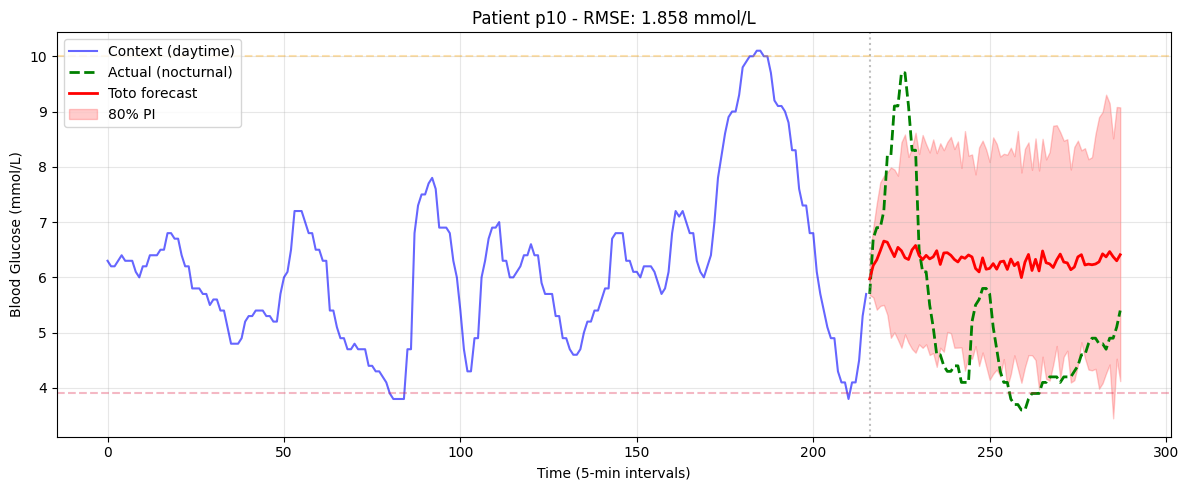

In [7]:
# Pick a patient and get first valid day
PATIENT = "p10"

patient_df = val_data[PATIENT]
for daytime, nocturnal in get_daytime_nocturnal_splits(patient_df):
    context = daytime[TARGET_COL].values
    target = nocturnal[TARGET_COL].values[:nocturnal_steps]
    
    if np.isnan(context).any() or np.isnan(target).any():
        continue
    if len(target) < nocturnal_steps:
        continue
    
    # Forecast
    pred, q10, q90 = toto_forecast(context, daytime.index, nocturnal_steps, num_samples=200)
    pred, q10, q90 = pred.flatten(), q10.flatten(), q90.flatten()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    t_ctx = np.arange(len(context))
    t_pred = np.arange(len(context), len(context) + len(target))
    
    ax.plot(t_ctx, context, 'b-', alpha=0.6, label='Context (daytime)')
    ax.plot(t_pred, target, 'g--', lw=2, label='Actual (nocturnal)')
    ax.plot(t_pred, pred, 'r-', lw=2, label='Toto forecast')
    ax.fill_between(t_pred, q10, q90, alpha=0.2, color='red', label='80% PI')
    
    ax.axvline(len(context), color='gray', ls=':', alpha=0.5)
    ax.axhline(3.9, color='crimson', ls='--', alpha=0.3)  # Hypoglycemia threshold
    ax.axhline(10.0, color='orange', ls='--', alpha=0.3)  # Hyperglycemia threshold
    
    rmse = compute_metrics(pred, target.flatten())['rmse']
    ax.set_title(f'Patient {PATIENT} - RMSE: {rmse:.3f} mmol/L')
    ax.set_xlabel('Time (5-min intervals)')
    ax.set_ylabel('Blood Glucose (mmol/L)')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    break

---

## Multivariate Forecasting

Toto supports multivariate input. Here we add IOB, COB, steps, and calories as exogenous features.

In [8]:
EXOG_FEATURES = [ColumnNames.IOB.value, ColumnNames.COB.value, ColumnNames.STEPS.value, ColumnNames.CALS.value]
ALL_FEATURES = [TARGET_COL] + EXOG_FEATURES

def toto_forecast_multivariate(context_df: pd.DataFrame, prediction_length: int, num_samples: int = 100):
    """
    Run Toto forecast with multivariate context.
    
    Args:
        context_df: DataFrame with columns [bg_mM, iob, cob, steps, cals]
    
    Returns: (median, q10, q90) for BG channel only
    """
    # Impute missing values
    df = context_df[ALL_FEATURES].copy()
    for col in [ColumnNames.IOB.value, ColumnNames.COB.value, TARGET_COL]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
    df[ColumnNames.STEPS.value] = df[ColumnNames.STEPS.value].fillna(0)
    df[ColumnNames.CALS.value] = df[ColumnNames.CALS.value].fillna(df[ColumnNames.CALS.value].min() or 0)
    
    context = df.values  # (timesteps, features)
    if np.isnan(context).any():
        return None, None, None
    
    # Prepare input: (features, timesteps)
    num_channels = len(ALL_FEATURES)
    series = torch.tensor(context.T, dtype=torch.float32).to(device)
    ts_seconds = torch.tensor(
        [ts.timestamp() for ts in context_df.index], dtype=torch.float32
    ).unsqueeze(0).expand(num_channels, -1).to(device)
    
    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_seconds,
        time_interval_seconds=torch.full((num_channels,), INTERVAL_MINS * 60, dtype=torch.float32).to(device),
    )
    
    with torch.no_grad():
        forecast = forecaster.forecast(inputs, prediction_length=prediction_length, num_samples=num_samples, samples_per_batch=50)
    
    # Extract BG channel (index 0)
    return forecast.median.cpu().numpy()[0, 0], forecast.quantile(0.1).cpu().numpy()[0, 0], forecast.quantile(0.9).cpu().numpy()[0, 0]

In [9]:
# Evaluate multivariate
all_preds_mv, all_targets_mv = [], []
patient_metrics_mv = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue
    if not all(f in patient_df.columns for f in ALL_FEATURES):
        continue
    
    preds, targets = [], []
    for daytime, nocturnal in get_daytime_nocturnal_splits(patient_df):
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]
        if np.isnan(target).any() or len(target) < nocturnal_steps:
            continue
        
        pred, _, _ = toto_forecast_multivariate(daytime, nocturnal_steps)
        if pred is None:
            continue
        
        preds.append(pred.flatten())
        targets.append(target.flatten())
    
    if preds:
        preds_flat = np.concatenate(preds)
        targets_flat = np.concatenate(targets)
        metrics = compute_metrics(preds_flat, targets_flat)
        patient_metrics_mv.append({'patient': patient_id, 'rmse': metrics['rmse'], 'mae': metrics['mae'], 'days': len(preds)})
        all_preds_mv.append(preds_flat)
        all_targets_mv.append(targets_flat)
        print(f"{patient_id}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(preds)} days)")

if all_preds_mv:
    overall_mv = compute_metrics(np.concatenate(all_preds_mv), np.concatenate(all_targets_mv))
    print(f"\nMultivariate Overall: RMSE={overall_mv['rmse']:.3f}, MAE={overall_mv['mae']:.3f}")

p03: RMSE=4.129, MAE=2.999 (19 days)
p02: RMSE=3.219, MAE=2.352 (17 days)
p04: RMSE=1.982, MAE=1.473 (19 days)
p11: RMSE=2.612, MAE=2.002 (18 days)
p12: RMSE=2.790, MAE=2.031 (18 days)
p10: RMSE=1.452, MAE=1.067 (18 days)

Multivariate Overall: RMSE=2.834, MAE=1.988


In [10]:
# Compare univariate vs multivariate
print("Univariate vs Multivariate Comparison")
print("=" * 40)
print(f"Univariate   RMSE: {overall['rmse']:.3f} mmol/L")
print(f"Multivariate RMSE: {overall_mv['rmse']:.3f} mmol/L")
improvement = (overall['rmse'] - overall_mv['rmse']) / overall['rmse'] * 100
print(f"Improvement: {improvement:+.1f}%")

Univariate vs Multivariate Comparison
Univariate   RMSE: 2.922 mmol/L
Multivariate RMSE: 2.834 mmol/L
Improvement: +3.0%


## Notes

**Key observations:**
- Toto provides probabilistic forecasts with uncertainty quantiles
- Multivariate input (with IOB, COB, activity) shows modest improvement
- Model does NOT handle NaN internally - must impute or skip

**Potential improvements:**
- Fine-tune on diabetes data
- Experiment with context lengths
- Use uncertainty for hypoglycemia risk assessment

## All Days Visualization

Compare univariate vs multivariate forecasts across all validation days for a patient.

Patient p10: 15 valid days


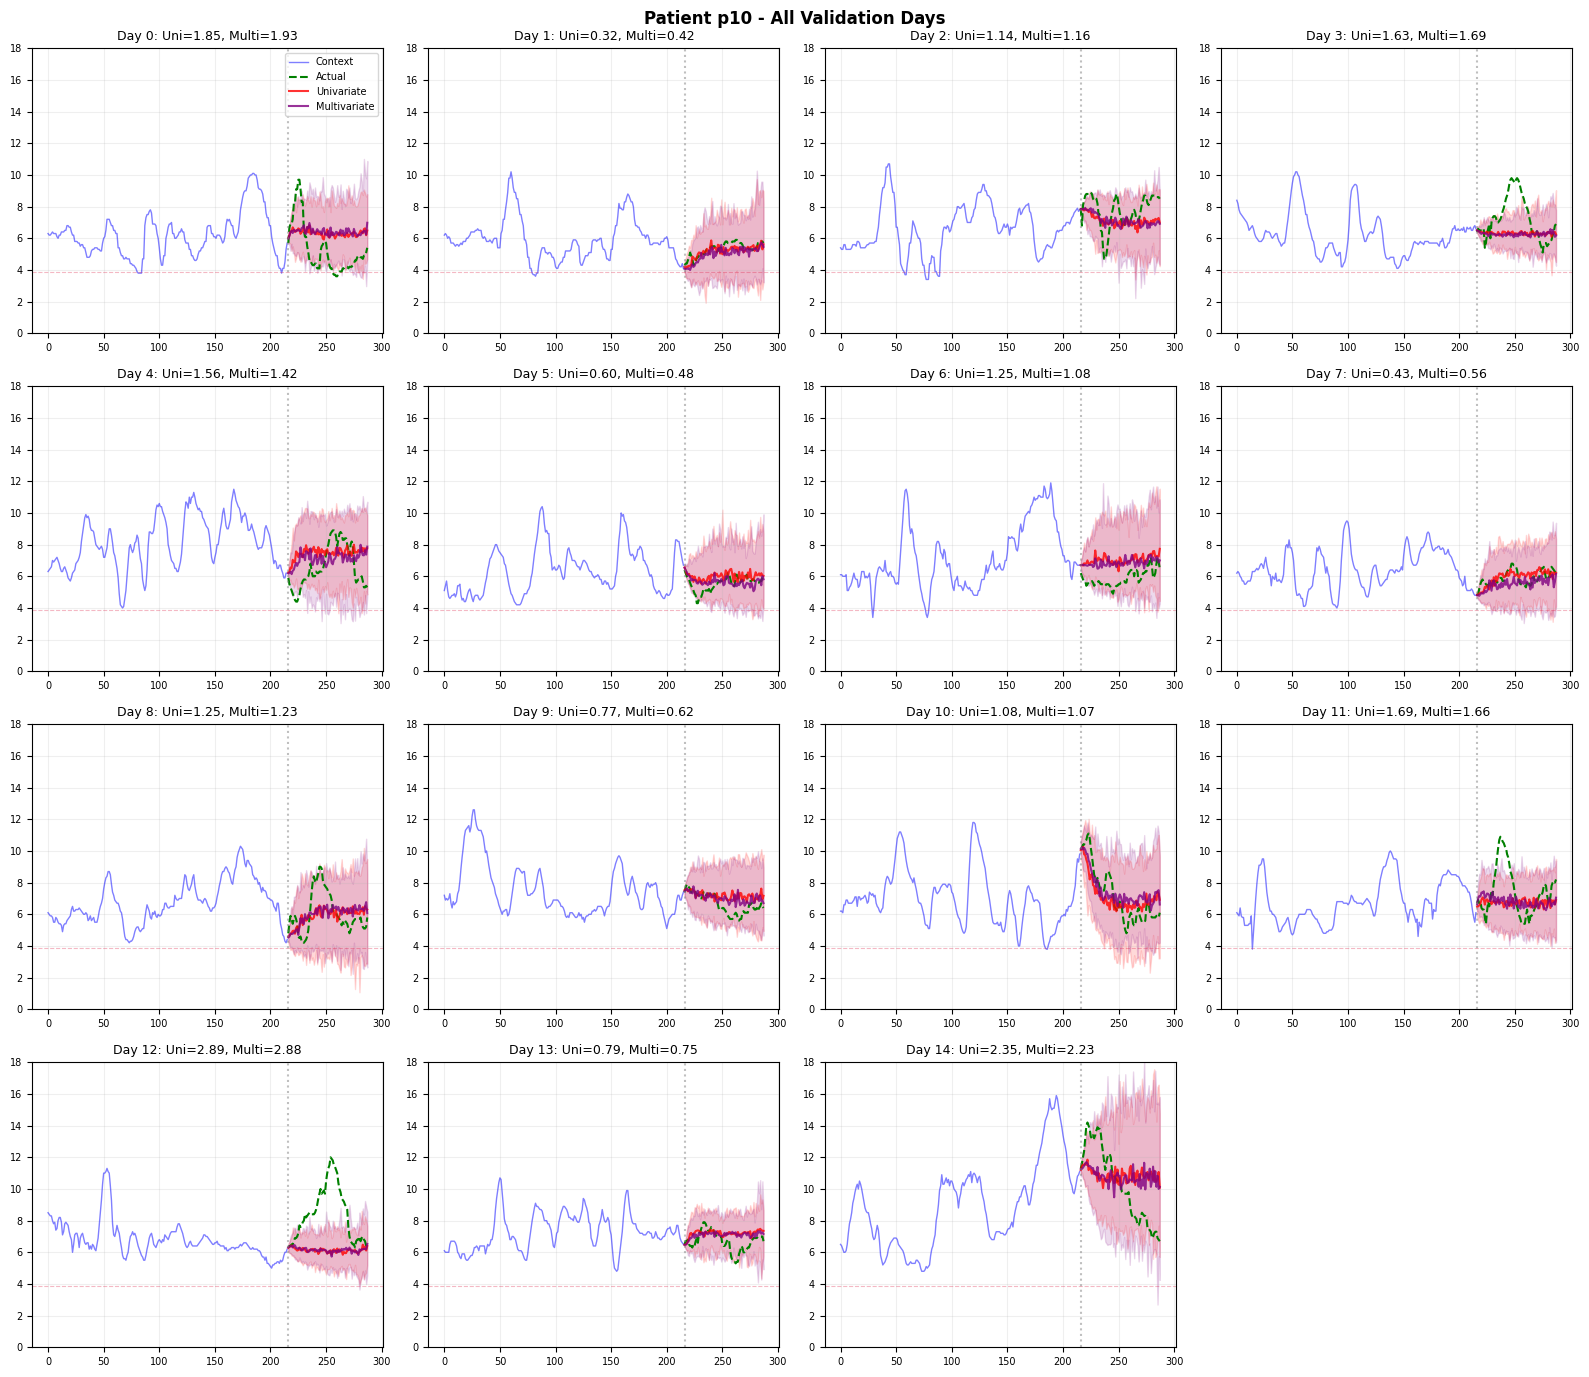


Avg Univariate RMSE: 1.307
Avg Multivariate RMSE: 1.278
Improvement: +2.2%


In [11]:
# === CONFIGURE ===
PLOT_PATIENT = "p10"
NCOLS = 4
NUM_SAMPLES = 100
# =================

patient_df = val_data[PLOT_PATIENT]
if get_interval_minutes(patient_df) != INTERVAL_MINS:
    print(f"Patient {PLOT_PATIENT} has incompatible interval")
else:
    # Collect valid days
    days = []
    for daytime, nocturnal in get_daytime_nocturnal_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]
        
        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue
        
        days.append({'daytime': daytime, 'context': context, 'target': target})
    
    num_days = len(days)
    print(f"Patient {PLOT_PATIENT}: {num_days} valid days")
    
    if num_days > 0:
        nrows = int(np.ceil(num_days / NCOLS))
        fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
        axes = np.array(axes).flatten() if num_days > 1 else [axes]
        
        results = []
        for i, day in enumerate(days):
            ax = axes[i]
            context, target, daytime = day['context'], day['target'], day['daytime']
            
            # Univariate forecast
            pred_uni, q10_uni, q90_uni = toto_forecast(context, daytime.index, nocturnal_steps, NUM_SAMPLES)
            pred_uni, q10_uni, q90_uni = pred_uni.flatten(), q10_uni.flatten(), q90_uni.flatten()
            
            # Multivariate forecast (if features available)
            pred_mv, q10_mv, q90_mv = None, None, None
            if all(f in daytime.columns for f in ALL_FEATURES):
                result = toto_forecast_multivariate(daytime, nocturnal_steps, NUM_SAMPLES)
                if result[0] is not None:
                    pred_mv, q10_mv, q90_mv = result[0].flatten(), result[1].flatten(), result[2].flatten()
            
            # Plot
            t_ctx = np.arange(len(context))
            t_pred = np.arange(len(context), len(context) + len(target))
            
            ax.plot(t_ctx, context, 'b-', alpha=0.5, lw=1, label='Context')
            ax.plot(t_pred, target, 'g--', lw=1.5, label='Actual')
            ax.plot(t_pred, pred_uni, 'r-', lw=1.5, alpha=0.8, label='Univariate')
            ax.fill_between(t_pred, q10_uni, q90_uni, alpha=0.15, color='red')
            
            if pred_mv is not None:
                ax.plot(t_pred, pred_mv, 'purple', lw=1.5, alpha=0.8, label='Multivariate')
                ax.fill_between(t_pred, q10_mv, q90_mv, alpha=0.15, color='purple')
            
            ax.axvline(len(context), color='gray', ls=':', alpha=0.5)
            ax.axhline(3.9, color='crimson', ls='--', alpha=0.3, lw=0.8)
            
            # Metrics
            rmse_uni = compute_metrics(pred_uni, target.flatten())['rmse']
            title = f"Day {i}: Uni={rmse_uni:.2f}"
            if pred_mv is not None:
                rmse_mv = compute_metrics(pred_mv, target.flatten())['rmse']
                title += f", Multi={rmse_mv:.2f}"
                results.append({'day': i, 'rmse_uni': rmse_uni, 'rmse_mv': rmse_mv})
            else:
                results.append({'day': i, 'rmse_uni': rmse_uni, 'rmse_mv': None})
            
            ax.set_title(title, fontsize=9)
            ax.set_ylim(0, 18)
            ax.tick_params(labelsize=7)
            ax.grid(alpha=0.2)
        
        # Hide unused subplots
        for j in range(num_days, len(axes)):
            axes[j].set_visible(False)
        
        axes[0].legend(fontsize=7, loc='upper right')
        fig.suptitle(f'Patient {PLOT_PATIENT} - All Validation Days', fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Summary
        results_df = pd.DataFrame(results)
        print(f"\nAvg Univariate RMSE: {results_df['rmse_uni'].mean():.3f}")
        if results_df['rmse_mv'].notna().any():
            print(f"Avg Multivariate RMSE: {results_df['rmse_mv'].mean():.3f}")
            improvement = (results_df['rmse_uni'].mean() - results_df['rmse_mv'].mean()) / results_df['rmse_uni'].mean() * 100
            print(f"Improvement: {improvement:+.1f}%")

---

## Context Length Experiment

Research suggests foundation models may benefit from longer context windows (512-2048 steps). 
Current daytime-only context provides ~216 steps. Let's test if more history improves forecasting.

**Hypothesis**: Providing previous nocturnal periods in context may help predict the current night.

In [12]:
# Context lengths to test (in 5-min steps)
CONTEXT_LENGTHS = [216, 512, 1024, 2048]  # ~18h, ~42h, ~85h, ~170h

def evaluate_with_context_length(context_len: int) -> dict:
    """Evaluate forecasting with a fixed context length across all patients."""
    all_preds, all_targets = [], []
    
    for patient_id, patient_df in val_data.items():
        if get_interval_minutes(patient_df) != INTERVAL_MINS:
            continue
        
        # Get full patient data sorted by time
        df = patient_df.sort_index()
        if TARGET_COL not in df.columns:
            continue
        
        # Slide through data: for each nocturnal period, get preceding context
        for daytime, nocturnal in get_daytime_nocturnal_splits(df):
            target = nocturnal[TARGET_COL].values[:nocturnal_steps]
            if np.isnan(target).any() or len(target) < nocturnal_steps:
                continue
            
            # Get context_len steps ending at midnight (start of nocturnal)
            nocturnal_start = nocturnal.index[0]
            mask = df.index < nocturnal_start
            available = df.loc[mask, TARGET_COL].dropna()
            
            if len(available) < context_len:
                continue  # Not enough history
            
            context = available.iloc[-context_len:].values
            timestamps = available.iloc[-context_len:].index
            
            if np.isnan(context).any():
                continue
            
            pred, _, _ = toto_forecast(context, timestamps, nocturnal_steps)
            all_preds.append(pred.flatten())
            all_targets.append(target.flatten())
    
    if not all_preds:
        return {'context_len': context_len, 'rmse': np.nan, 'mae': np.nan, 'n_samples': 0}
    
    metrics = compute_metrics(np.concatenate(all_preds), np.concatenate(all_targets))
    return {'context_len': context_len, 'hours': context_len * INTERVAL_MINS / 60, 
            'rmse': metrics['rmse'], 'mae': metrics['mae'], 'n_samples': len(all_preds)}

# Run experiment
print("Testing context lengths...")
results = []
for ctx_len in CONTEXT_LENGTHS:
    print(f"  Context: {ctx_len} steps ({ctx_len * INTERVAL_MINS / 60:.0f} hours)...", end=" ")
    result = evaluate_with_context_length(ctx_len)
    print(f"RMSE={result['rmse']:.3f} (n={result['n_samples']})")
    results.append(result)

context_df = pd.DataFrame(results)
context_df

Testing context lengths...
  Context: 216 steps (18 hours)... RMSE=2.855 (n=104)
  Context: 512 steps (43 hours)... RMSE=2.515 (n=99)
  Context: 1024 steps (85 hours)... RMSE=2.505 (n=92)
  Context: 2048 steps (171 hours)... RMSE=2.528 (n=73)


,context_len,hours,rmse,mae,n_samples
0,216,18.000000,2.855495,2.012734,104
1,512,42.666667,2.514637,1.845783,99
2,1024,85.333333,2.505159,1.801451,92
3,2048,170.666667,2.527607,1.820584,73


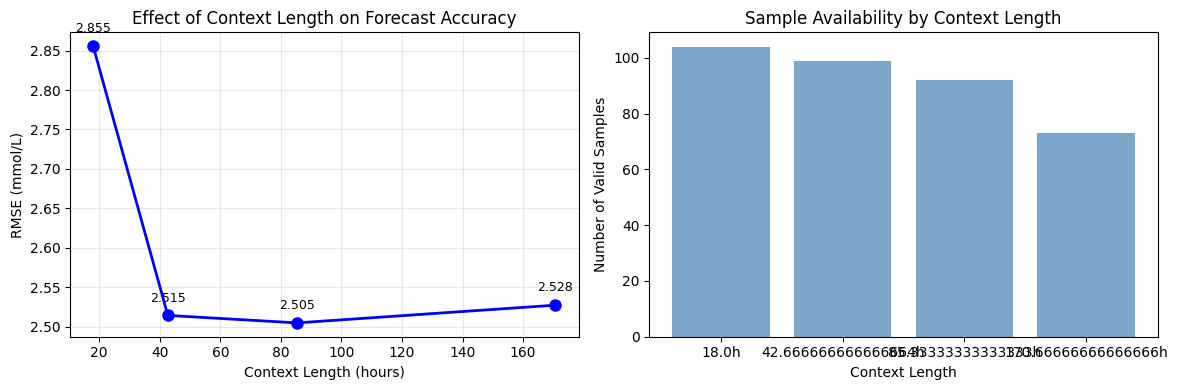


Best context length: 85 hours (1024 steps)
Best RMSE: 2.505 mmol/L

Note: Longer contexts require more historical data, reducing valid samples.


In [13]:
# Visualize context length effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE by context length
ax = axes[0]
ax.plot(context_df['hours'], context_df['rmse'], 'bo-', lw=2, markersize=8)
ax.set_xlabel('Context Length (hours)')
ax.set_ylabel('RMSE (mmol/L)')
ax.set_title('Effect of Context Length on Forecast Accuracy')
ax.grid(alpha=0.3)
for _, row in context_df.iterrows():
    ax.annotate(f"{row['rmse']:.3f}", (row['hours'], row['rmse']), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

# Sample counts
ax = axes[1]
ax.bar(context_df['hours'].astype(str) + 'h', context_df['n_samples'], color='steelblue', alpha=0.7)
ax.set_xlabel('Context Length')
ax.set_ylabel('Number of Valid Samples')
ax.set_title('Sample Availability by Context Length')

plt.tight_layout()
plt.show()

# Summary
best = context_df.loc[context_df['rmse'].idxmin()]
print(f"\nBest context length: {best['hours']:.0f} hours ({best['context_len']:.0f} steps)")
print(f"Best RMSE: {best['rmse']:.3f} mmol/L")
print(f"\nNote: Longer contexts require more historical data, reducing valid samples.")

### Context Length Findings

**Interpretation:**
- Research on other TSFMs found diminishing returns beyond 512 steps
- For blood glucose, including previous nocturnal periods in context may help the model recognize patterns
- Trade-off: longer context = fewer valid samples (patients need sufficient history)

**Key insight:** Toto uses relative positional embeddings (RoPE), not explicit timestamps. It learns patterns from the *shape* of the data, not "this is midnight." More context helps if it contains relevant repeating patterns.

---

## Evaluation with Optimal Context Length

Re-run visualization with 1024-step context (~85 hours) to see if predictions improve.

In [19]:
# === CONFIGURE ===
PLOT_PATIENT = "p10"
OPTIMAL_CONTEXT = 1024  # Best from experiment (~85 hours)
NCOLS = 4
NUM_SAMPLES = 100
# =================

patient_df = val_data[PLOT_PATIENT].sort_index()

# Collect valid days with extended context
days_extended = []
for daytime, nocturnal in get_daytime_nocturnal_splits(patient_df):
    target = nocturnal[TARGET_COL].values[:nocturnal_steps]
    if np.isnan(target).any() or len(target) < nocturnal_steps:
        continue
    
    # Get extended context (all data before midnight)
    nocturnal_start = nocturnal.index[0]
    available = patient_df.loc[patient_df.index < nocturnal_start, TARGET_COL].dropna()
    
    if len(available) < OPTIMAL_CONTEXT:
        continue
    
    context = available.iloc[-OPTIMAL_CONTEXT:].values
    timestamps = available.iloc[-OPTIMAL_CONTEXT:].index
    short_context = daytime[TARGET_COL].values  # Original ~18h context
    short_timestamps = daytime.index
    
    if np.isnan(context).any() or np.isnan(short_context).any():
        continue
    
    days_extended.append({
        'context': context, 'timestamps': timestamps,
        'short_context': short_context, 'short_timestamps': short_timestamps,
        'target': target
    })

print(f"Patient {PLOT_PATIENT}: {len(days_extended)} days with sufficient history for {OPTIMAL_CONTEXT}-step context")

Patient p10: 14 days with sufficient history for 1024-step context


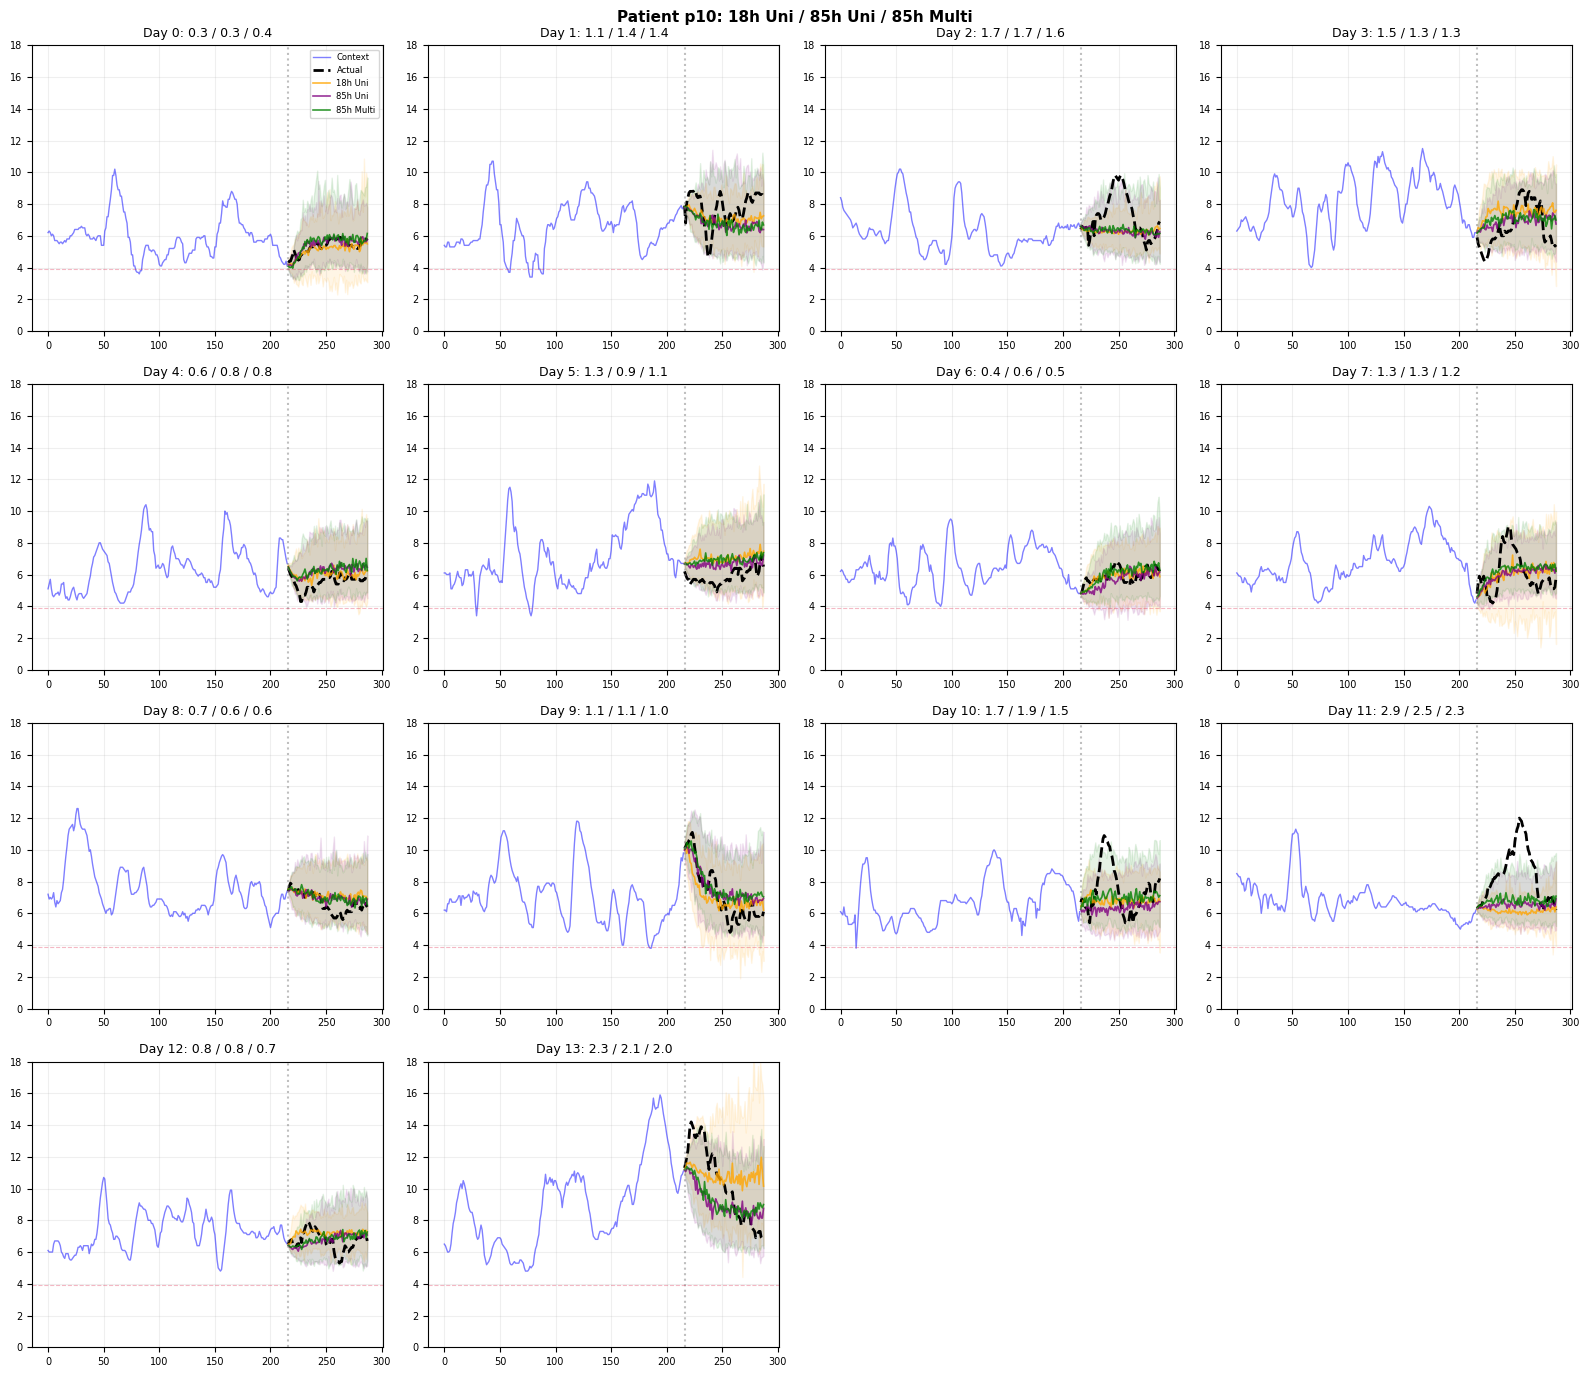


Approach        Avg RMSE  
-------------------------
18h Uni         1.266
85h Uni         1.231
85h Multi       1.193

Improvement over 18h Uni: Ext Uni +2.8%, Ext Multi +5.8%


In [20]:
# Helper for extended multivariate context
def get_extended_multivariate_context(patient_df, nocturnal_start, context_len):
    available = patient_df.loc[patient_df.index < nocturnal_start].dropna(subset=[TARGET_COL])
    if len(available) < context_len:
        return None, None
    df = available.iloc[-context_len:][ALL_FEATURES].copy()
    for col in [ColumnNames.IOB.value, ColumnNames.COB.value, TARGET_COL]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
    df[ColumnNames.STEPS.value] = df[ColumnNames.STEPS.value].fillna(0)
    df[ColumnNames.CALS.value] = df[ColumnNames.CALS.value].fillna(df[ColumnNames.CALS.value].min() or 0)
    return (df.values, df.index) if not df.isna().any().any() else (None, None)

def forecast_multivariate_extended(mv_context, mv_timestamps, pred_len, num_samples):
    num_ch = len(ALL_FEATURES)
    series = torch.tensor(mv_context.T, dtype=torch.float32).to(device)
    ts_sec = torch.tensor([t.timestamp() for t in mv_timestamps], dtype=torch.float32).unsqueeze(0).expand(num_ch, -1).to(device)
    inputs = MaskedTimeseries(
        series=series, padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series), timestamp_seconds=ts_sec,
        time_interval_seconds=torch.full((num_ch,), INTERVAL_MINS * 60, dtype=torch.float32).to(device))
    with torch.no_grad():
        fc = forecaster.forecast(inputs, prediction_length=pred_len, num_samples=num_samples, samples_per_batch=50)
    return fc.median.cpu().numpy()[0, 0].flatten(), fc.quantile(0.1).cpu().numpy()[0, 0].flatten(), fc.quantile(0.9).cpu().numpy()[0, 0].flatten()

# Plot all three approaches
num_days = len(days_extended)
nrows = int(np.ceil(num_days / NCOLS))
fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
axes = np.array(axes).flatten() if num_days > 1 else [axes]

results = []
for i, day in enumerate(days_extended):
    ax = axes[i]
    target = day['target']
    nocturnal_start = day['timestamps'][-1] + pd.Timedelta(minutes=INTERVAL_MINS)
    
    # All forecasts
    pred_short, q10_short, q90_short = [x.flatten() for x in toto_forecast(day['short_context'], day['short_timestamps'], nocturnal_steps, NUM_SAMPLES)]
    pred_ext, q10_ext, q90_ext = [x.flatten() for x in toto_forecast(day['context'], day['timestamps'], nocturnal_steps, NUM_SAMPLES)]
    
    mv_context, mv_ts = get_extended_multivariate_context(patient_df, nocturnal_start, OPTIMAL_CONTEXT)
    pred_mv, q10_mv, q90_mv = forecast_multivariate_extended(mv_context, mv_ts, nocturnal_steps, NUM_SAMPLES) if mv_context is not None else (None, None, None)
    
    # Plot
    ctx_display = day['context'][-216:]
    t_ctx, t_pred = np.arange(len(ctx_display)), np.arange(len(ctx_display), len(ctx_display) + len(target))
    
    ax.plot(t_ctx, ctx_display, 'b-', alpha=0.5, lw=1, label='Context')
    ax.plot(t_pred, target, 'k--', lw=2, label='Actual')
    for pred, q10, q90, color, lbl in [(pred_short, q10_short, q90_short, 'orange', '18h Uni'),
                                        (pred_ext, q10_ext, q90_ext, 'purple', '85h Uni'),
                                        (pred_mv, q10_mv, q90_mv, 'green', '85h Multi')]:
        if pred is not None:
            ax.plot(t_pred, pred, color, lw=1.2, alpha=0.8, label=lbl)
            ax.fill_between(t_pred, q10, q90, alpha=0.1, color=color)
    
    ax.axvline(len(ctx_display), color='gray', ls=':', alpha=0.5)
    ax.axhline(3.9, color='crimson', ls='--', alpha=0.3, lw=0.8)
    
    r = {k: compute_metrics(p, target)['rmse'] if p is not None else np.nan 
         for k, p in [('short', pred_short), ('ext', pred_ext), ('multi', pred_mv)]}
    results.append(r)
    ax.set_title(f"Day {i}: {r['short']:.1f} / {r['ext']:.1f} / {r['multi']:.1f}", fontsize=9)
    ax.set_ylim(0, 18); ax.tick_params(labelsize=7); ax.grid(alpha=0.2)

for j in range(num_days, len(axes)): axes[j].set_visible(False)
axes[0].legend(fontsize=6, loc='upper right')
fig.suptitle(f'Patient {PLOT_PATIENT}: 18h Uni / 85h Uni / 85h Multi', fontsize=11, fontweight='bold')
plt.tight_layout(); plt.show()

# Summary
df = pd.DataFrame(results)
print(f"\n{'Approach':<15} {'Avg RMSE':<10}")
print("-" * 25)
for col, name in [('short', '18h Uni'), ('ext', '85h Uni'), ('multi', '85h Multi')]:
    print(f"{name:<15} {df[col].mean():.3f}")
baseline = df['short'].mean()
print(f"\nImprovement over 18h Uni: Ext Uni {(baseline - df['ext'].mean())/baseline*100:+.1f}%, Ext Multi {(baseline - df['multi'].mean())/baseline*100:+.1f}%")